<center><h1>QBUS6840 - Predictive Analytics </h1></center>

# Tutorial 9 – ARIMA Models (II)
 
### Objectives:

- Analyze MA($q$), ARMA($p,q$) and ARIMA($p,d,q$) models
- Fit ARIMA($p,d,q$) models to observed data and forecasting with the fitted ARIMA($p,d,q$) models 

### 1.3. Backshift operator

In many textbooks, the AR, MA, or AR(I)MA are often expressed using backshift notations. In essence, applying a backshift operator B to an observation shift the time stamp back by one step: $BY_t = Y_{t−1}$.

We can apply this repeatedly, for example: $B^2 Y_t = B(BY_t) = BY_{t−1} = Y{t−2}$, or $B^kY_t = Y_{t−k}$. Let’s look at a few example how this operator can simplify the notation.

Consider an AR(1) process: $Y_t=c+\phi_1Y_{t-1}+\varepsilon_t$ or $(1-\phi_1B)Y_t=c+\varepsilon_t$. We derived in the last lecture that 
$\mu = E(Y_t)=E(Y_{t-1}) = c/(1-\phi_1)$. 

Thus, $(1-\phi_1B)(Y_t-\mu)=\varepsilon_t$ which comes from the fact $c = (1-\phi_1)\mu = (1 - \phi_1B)\mu$, which is from $B d= d$ for any constant $d$. Denote $Z_t = Y_t - \mu$, then $(1-\phi_1B)Z_t=\varepsilon_t \Longrightarrow Z_t = \phi_1Z_{t-1} + \varepsilon_t$. 

This suggests that we can equivalently re-parameterise an $AR(1)$ process with an intercept with a model that has no intercept.

We can write an $AR(p)$ process as follows,

\begin{align*}
    Y_t &=c+\phi_1Y_{t-1}+\ldots+\phi_pY_{t-p}+\varepsilon_t\\
        &=c+\phi_1B(Y_{t})+\ldots+\phi_pB^p(Y_{t})+\varepsilon_t.
        \tag{4}
\end{align*}

Moving the term with the backshift operators to the left hand side and noting that $\mu = c/(1-\phi_1 - \phi_2-\cdots-\phi_p)$ give:

\begin{align*}
    (1-\phi_1B-\phi_2B^2-\ldots-\phi_pB^p)(Y_t-\mu)=\varepsilon_t \\
    \text{or} \quad (1-\sum_{i=1}^p\phi_iB^i)(Y_t-\mu)=\varepsilon_t
    \tag{5}
\end{align*}

We can do the same thing for MA($q$) as follows,

\begin{align*}
    Y_t
        &=c+\theta_1\varepsilon_{t-1}+\ldots+\theta_q\varepsilon_{t-q}+\varepsilon_t\\
        &=c+\theta_1B(\varepsilon_{t})+\ldots+\theta_qB^q(\varepsilon_{t})+\varepsilon_t
        \tag{6}
\end{align*}

Noting that the mean function $\mu = c$, we can arrive at:

\begin{align*} 
Y_t-\mu=(1+\theta_1B+\theta_2B^2+\ldots+\theta_qB^q)\varepsilon_t \\
\text{or}\quad Y_t-\mu=(1+\sum_{i=1}^q\theta_iB^i)\varepsilon_t
\tag{7}
\end{align*}

We can write ARMA and ARIMA using the backshift notation in a similar vein,

\begin{align*}
    \text{ARMA}(p, q) \qquad \left(1-\sum_{i=1}^p\phi_iB^i\right)Y_t=c+\left(1+\sum_{i=1}^q\theta_iB^i\right)\varepsilon_t, \\
    \text{ARIMA}(p, d, q) \qquad \left(1-\sum_{i=1}^p\phi_iB^i\right)(1-B)^d Y_t=c+\left(1+\sum_{i=1}^q\theta_iB^i\right)\varepsilon_t,
    \tag{8}
\end{align*}

### 1.4. Invertibility

Any stationary $AR(p)$ model can be written as an MA model of infinite order. However, the reverse holds only for invertible MA processes.

An $MA(q)$ process is *invertible* when we can rewrite it as a linear combination of its *past* values (an $AR(\infty)$) plus the contemporaneous error term.

    
For example, consider an $MA(1)$ process without intercept, $Y_t = \theta_1\varepsilon_{t-1} + \varepsilon_t$, or 

\begin{align}
    \varepsilon_t = \frac{Y_t}{(1+\theta_1B)}
\end{align}

Note that $\frac1{1+x} = 1 - x + x^2 - x^3 + \cdots$ when $|x|<1$. Under the condition $|\theta_1|<1$, we have

\begin{align*}
    \varepsilon_t 
    &=(1-\theta_1B+\theta_1^2B^2-\theta_1^3B^3+\ldots) Y_t\\
    &= Y_t-\theta_1BY_t + \theta^2_1B^2Y_t - \cdots
\end{align*}

or

\begin{align*}
    Y_t= -\sum_{i=1}^{\infty}(-1)^i\theta_1^iY_{t-i}+\varepsilon_t
\end{align*}

Thus we need $|\theta_1|<1$ for an MA(1) process to be invertible. When $|\theta_1| \geq 1$, the series above does not converge to a finite value. Another way to think of invertibility is that an invertible MA model is one that can be written as an AR model of infinite order so that the AR coefficients converge to 0 as we move infinitely back in time. Invertibility matters as many convenient algorithms for estimating parameters and forecasting are only valid if we use an invertible representation. That said, many modern software packages are capable of ensuring that parameter estimates correspond to an invertible model so you almost always don't have to worry about this.

**Note:** Students should review lecture slides of Week 08 for a completed discussion on the invertibility. 

## 2.  Working with  ARIMA  models in `statsmodels`

Similar to the previous tutorial, it is always useful to visualize and analyze sample realisation from the stochastic processes of interests. In this example, let's generate sample data from a ARMA process using `statsmodels`.  

### Step 1: Set parameters for an ARMA (1,2) process

Import required libraries

In [7]:
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as smt
import numpy as np
import pandas as pd

In [8]:
#!pip install statsmodels

Set up the parameters for an $ARMA(1,2)$ process

$$
Y_t = 0 + 0.9 Y_{t-1} + 0.6 \varepsilon_{t-1} - 0.2 \varepsilon_{t-2} + \varepsilon_t, \;\;\; \varepsilon_t \sim (0,1)
$$

In [9]:
np.random.seed(1)                # To replicate the results
arparams = np.array([0.9])       # Parameter for AR(1)
zero_lag = np.array([1])
maparams = np.array([0.6, -0.2]) # Parameters for MA(2)
ar = np.r_[1, -arparams]         # Add zero-lag (coefficient 1) and negate
ma = np.r_[1, maparams]          # Add zero-lag
c = 0                            # Constant
sigma2 = 1                       # Variance of the noise

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Why do we use `ar = np.r_[1, -arparams]` to define the AR coefficient?

Note that we add a negative sign in front of arparams. The reason for this is, we write a general $ARMA(p,q)$ process in the following way:

$$
Y_t = c + \phi Y_{t-1} +...+ \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + ... + \theta_q \varepsilon_{t-q} + \epsilon_t
$$

But `statsmodels` defines an $ARMA(p,q)$ process as:

$$
Y_t = c - \phi Y_{t-1} -...- \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + ... + \theta_q \varepsilon_{t-q} + \epsilon_t
$$

Given the definition in the python code, we have and ARMA($1,2$) process with $\phi_1=0.9$, $\theta_1 = 0.6$, $\theta_2 = -0.2$.

It is `statsmodels` requirement that we must add $1$, e.g. *zero lag*, to both `ar` and `ma` coefficients.

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Can you check the stationarity of the example ARMA process?

### Step 2. Generate a sample series from the $MA (2)$, or $ARMA(0,2)$, process with the given coefficients

With the `statsmodels` libraries, an ARMA($p,q$) model is given by an ARMA($p,q$) model object as shown in the following code:

MA Model is stationary
MA Model is invertible


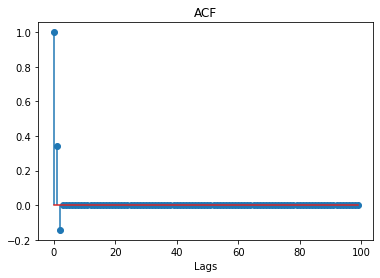

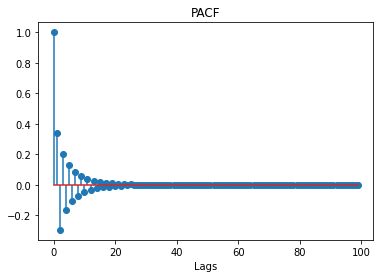

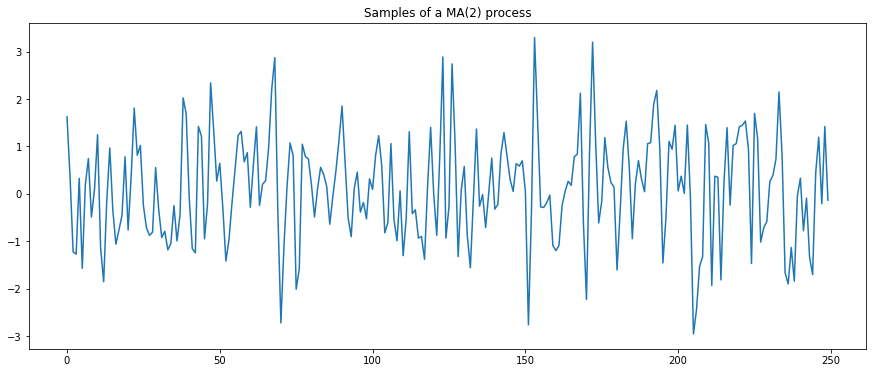

In [10]:
ma_model = sm.tsa.arima_process.ArmaProcess(ar = zero_lag, ma = ma)

# Check if it is stationary
print("MA Model is{0}stationary".format(" " if ma_model.isstationary else " not " ))

# Check if it is invertible
print("MA Model is{0}invertible".format(" " if ma_model.isinvertible else " not " ))

# Plot ACF (Theoretical)
plt.stem(ma_model.acf(),use_line_collection=True)
plt.title('ACF')
plt.xlabel('Lags')
plt.show()

# Plot PACF (Theoretical)
plt.stem(ma_model.pacf(),use_line_collection=True)
plt.title('PACF')
plt.xlabel('Lags')
plt.show()

# Generate samples
n_samples = 250
y2 = c + ma_model.generate_sample(n_samples)

# Plot the sample series
plt.figure(figsize=(15,6))
plt.plot(y2)
plt.title("Samples of a MA(2) process")
plt.show()

**Note 1**: The first statement creates an $ARMA(p,q)$ model. As we set `ar = zero_lag` which is $1$, so we end up with an MA($q$) model. Actually `sm.tsa.arima_process.ArmaProcess` produces for theoretical analysis, e.g. theoretical ACF/PACF. Unfortunately, it only produces a process without the intercept $c$ (i.e., $c = 0$).

**Note 2**: We can produce the theoretical ACF and PACF in statements 5 and 6 BEFORE we generate any samples! For MA($2$) process the theoretical ACF should cut off after lag $2$ and theoretical PACF should die down exponentially.

**Note 3**: After we have created an ARMA model object (in this example, a $MA(2)$ model object), we can produce time series sample, as shown in the statement for `y2`.

### Step 3. Check the Sample ACF and PACF

Now we show the sample ACF and PACF from the time series `y2`

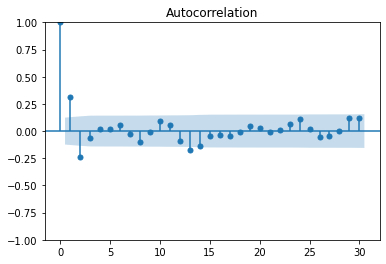

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


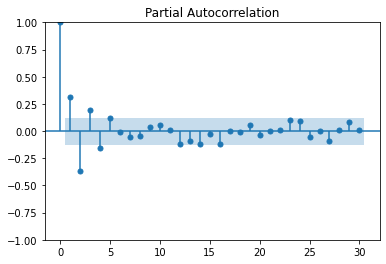

In [23]:
# Sample ACF
smt.graphics.tsa.plot_acf(y2, lags=30, alpha = 0.05)
plt.show()

# Sample PACF
smt.graphics.tsa.plot_pacf(y2, lags=30, alpha = 0.05)
plt.show()

You may compare these sample ACF and PACF with the theoretical ACF and PACF.

Calculate the unconditional mean and variance.

In [12]:
# Mean
# Since epsilon_t ~ N(0, sigma^2)
# then E(epsilon_t) = 0
y2_mean = c

# Variance
# c is constant so var(c) = 0
# var(epsilon_t) = sigma^2
# then var(y2) = 0 + sigma^2 + theta_1^2 * sigma^2 + theta_2^2 * sigma^2
y2_variance = sigma2 * (1 + maparams[0]**2 + maparams[1]**2)

print('Unconditional mean    : ',c)
print('Unconditional variance: {:.2f} '.format(y2_variance))

Unconditional mean    :  0
Unconditional variance: 1.40 


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Compare the unconditional mean and sample mean. Are they similar? If not, how to make sample mean be closer to the unconditional mean? The same question for the unconditional variance and sample variance. 

### Step 4. Generate a sample series from a $ARMA (1, 2)$ process with given parameters.

Now combine both $AR(1)$ and $MA(2)$ parameters to produce an $ARMA(1,2)$ process.

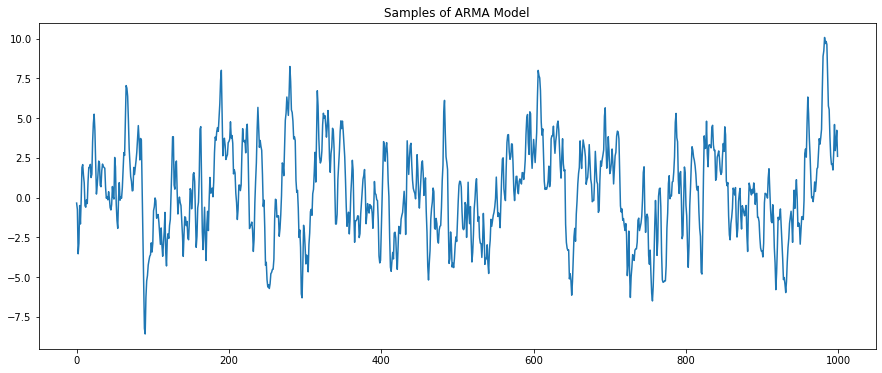

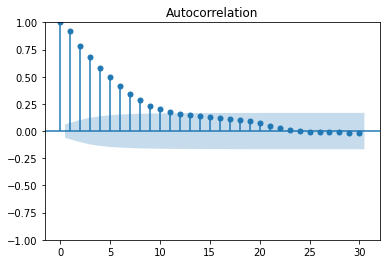

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


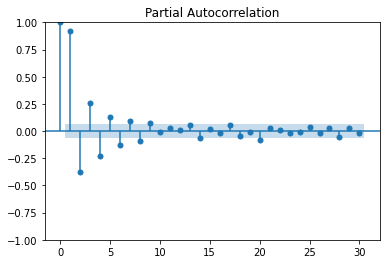

In [13]:
# Sample size
n_samples = 1000

# Define an ARMA(1,2) object
arma_model = sm.tsa.arima_process.ArmaProcess(ar = ar, ma = ma)

# Generate a sample of 1000 observations
#Yt = 0.9Y_{t-1} + 0.6e_{t-1} - 0.5 e_{t-2} + e_t
y3 = arma_model.generate_sample(n_samples)

# Plot the sample series
plt.figure(figsize=(15,6))
plt.plot(y3)
plt.title("Samples of ARMA Model")
plt.show()

# Plot sample ACF
smt.graphics.tsa.plot_acf(y3, lags=30, alpha = 0.05)
plt.show()

# Plot sample PACF
smt.graphics.tsa.plot_pacf(y3, lags=30, alpha = 0.05)
plt.show()

### Step 5. Model Fitting

Now let's try and fit a model to these samples and compare the parameters with those that we actually specified. As we have already known the true models, we will fit $ARMA(0,2)$ and $ARMA(1,2)$ models to `y2` and `y3`, respectively. 

In [14]:
# Import ARIMA class
from statsmodels.tsa.arima.model import ARIMA

# Fit the model back
# (0,0,2) refers to the MA(2) model in ARIMA representation
model_y2 = ARIMA(y2, order=(0,0,2)).fit()

# Get the summary of the fitted model
print(model_y2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -339.581
Date:                Mon, 02 May 2022   AIC                            687.161
Time:                        13:19:23   BIC                            701.247
Sample:                             0   HQIC                           692.830
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1097      0.078      1.398      0.162      -0.044       0.263
ma.L1          0.5462      0.060      9.044      0.000       0.428       0.665
ma.L2         -0.2283      0.058     -3.956      0.0

In [15]:
# (1,0,2) refers to the ARMA(1,2) model in ARIMA representation
model_y3 = ARIMA(y3, order=(1,0,2)).fit()
print("Estimated Model Parameters of an ARMA(1,2) model for y3: " + str(model_y3.params))

# Get the summary of the fitted model
print(model_y3.summary())

Estimated Model Parameters of an ARMA(1,2) model for y3: [ 0.34499946  0.87179365  0.61887853 -0.14128529  0.97975306]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1410.175
Date:                Mon, 02 May 2022   AIC                           2830.350
Time:                        13:19:23   BIC                           2854.889
Sample:                             0   HQIC                          2839.677
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3450      0.361      0.956      0.339      -0.362       1.052
ar.L1       

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Read the estimation results from two models, are they similar to the true models? why? 

## 3. Forecasting with ARIMA

In the previous task, we have learnt how to define a $ARMA(p,q)$ process for given model parameters and how to train an $ARMA(p,q)$ model on a given time series data by using `statsmodel` library. In this task, we will use $ARIMA(p,q,d)$ model to forecast the computer sale dataset

### Step 1. Load the dataset

Download the dataset from the Canvas website, and then copy the following code to your python editor.

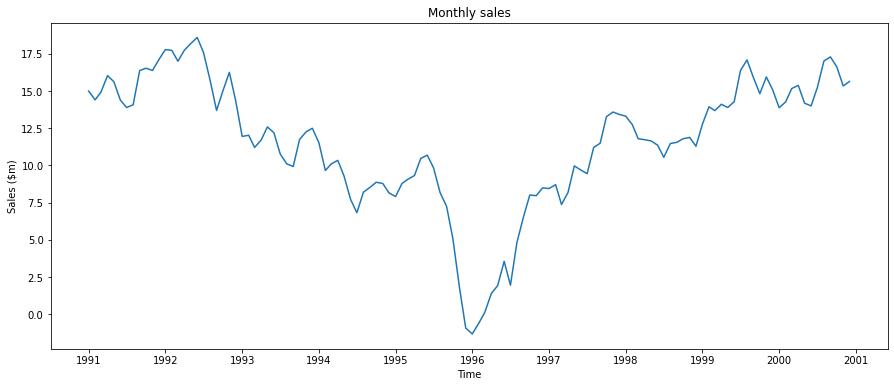

In [16]:
# Then read the data file into a DataFrame object
data = pd.read_csv('ComputerSales.csv')
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.head()

# Extract month sales (in $m)
sales = data['Sale']

# Plot data
plt.figure(figsize=(15,6))
plt.plot(sales.index,data)
plt.xlabel('Time')
plt.ylabel('Sales ($m)')
plt.title('Monthly sales')
plt.show()

### Step 3. $1^{st}$ differencing

Clearly the time is not stationary as it has increasing trend (we need to check the sample ACF too!). Though the $ARIMA(p,d,q)$ does not require a stationary data as input, we still need to access the stationarity of the time series to select appropriated integrated value $d$. Therefore, we will do the $1^{st}$ order difference. If the $1^{st}$ order difference series is still not stationary, we will then do $2^{nd}$ diff, etc., until we can decide an appropriated order for $d$. Here, we firstly start with trying the $1^{st}$ order difference.

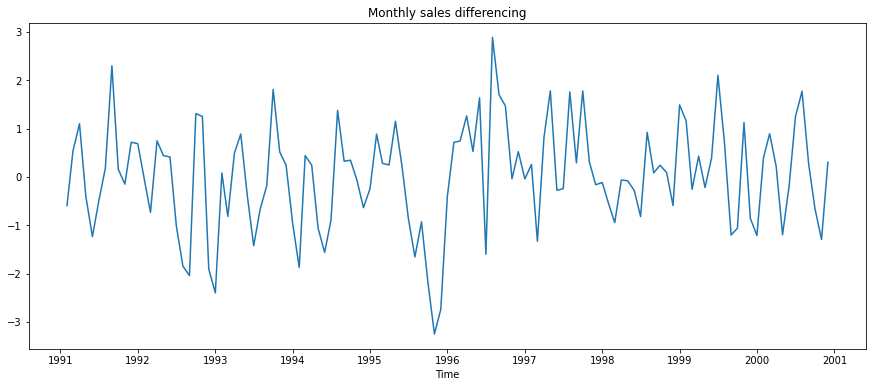

In [17]:
# We calculate difference series, Y[1]-Y[0], Y[2]-Y[1],...
sales_diff = pd.Series.diff(sales)

# Discard the nan value
sales_diff = sales_diff.dropna()

# Plot the differenced data
plt.figure(figsize=(15,6))
plt.plot(sales_diff)
plt.xlabel('Time')
plt.title('Monthly sales differencing')
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Why do we need to call `dropna()` function in here?

To ensure that the transformed series is stationary, we may carefully check its sample ACF. We will do it in the following step.

### Step 4. ACF and PACF of the $1^{st}$ differencing data

Then we examine the ACF and PACF plot to obtain a suitable order for AR($p$) and MA(q) process. Run the following code and answer the following question:

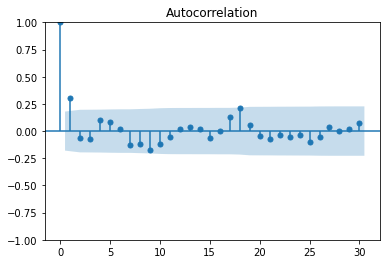

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


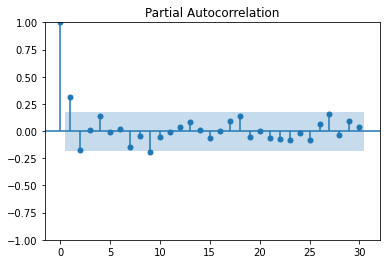

In [18]:
# Sample ACF
smt.graphics.tsa.plot_acf(sales_diff, lags=30, alpha = 0.05)
plt.show()

# Sample PACF
smt.graphics.tsa.plot_pacf(sales_diff, lags=30, alpha = 0.05)
plt.show()

The sample ACF die down quickly and cut-off after lag 1. In this case, it's reasonable to say that the differenced data is stationary and hence we don't need to apply another differencing step. Then we could set the $d=1$ for the $ARIMA(p,d,q)$ process.


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Examine the PACF plot, what is the suitable order p for AR process?
- Examine the ACF plot, what is the suitable order q for MA process?

For our purpose of showing how to do ARIMA modeling, we decide to select $p = 1$ and $q = 1$. That is we are looking at $ARIMA(1, 1, 1)$.

### Step 5. Fit a ARIMA (1,1,1) model to the differenced data

Run the following code and check the fitted results

In [19]:
# Create an ARIMA (1,1,1) model
model = ARIMA(sales, order=(1, 1, 1))
model_fit = model.fit()

# Get the summary of the fitted model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Sale   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -172.980
Date:                Mon, 02 May 2022   AIC                            351.960
Time:                        13:19:24   BIC                            360.298
Sample:                    01-01-1991   HQIC                           355.346
                         - 12-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0252      0.248      0.101      0.919      -0.461       0.511
ma.L1          0.3321      0.237      1.403      0.161      -0.132       0.796
sigma2         1.0706      0.136      7.873      0.0

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Why we need to input `sales` for ARIMA rather than `sales_diff`?

It's useful to plot the fitted and true values to see the in-sample performance of the ARIMA model for this dataset. The fitted values are obtained using the `predict()` method of the fitted ARIMA object. We can also make the forecast for unseen data using the `predict()` method. 

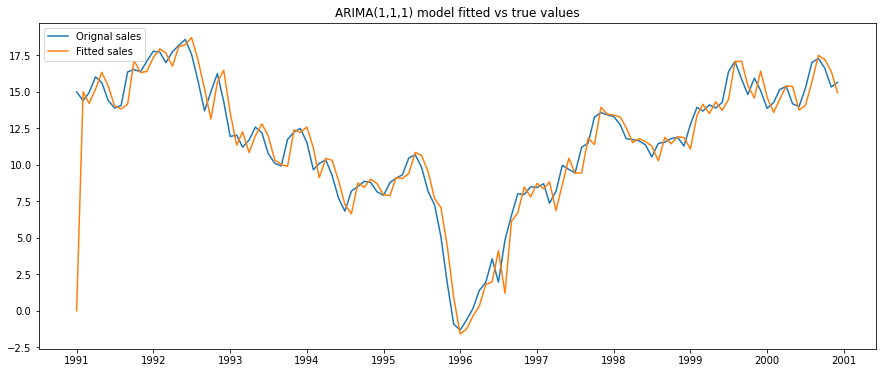

In [20]:
# Get Fitted Series
sales_fitted = model_fit.predict()

# Actual vs Fitted
plt.figure(figsize=(15,6))
plt.plot(sales,label='Orignal sales')
plt.plot(sales_fitted,label='Fitted sales')
plt.title("ARIMA(1,1,1) model fitted vs true values")
plt.legend(loc=2)
plt.show()

**Note**: Here fitted means fitting the `sales`. `dynamic = False` means that the in-sample lagged values are used for prediction.

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - statsmodels.tsa.arima.model.ARIMA class </h3></div>

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

### Step 6. Using AIC to select best fitting (p,q) order of ARIMA(p,d,q) models (Optional)

AIC function is useful in selecting predictors for regression. It is also useful for determining the order of an ARIMA($p,q,d$) model.

From `statsmodel` library, you can call `arma_order_select_ic()` function to select the best fitting order of an ARIMA($p,q,d$) model:

In [21]:
import statsmodels.tsa.stattools as st 

order = st.arma_order_select_ic(sales_diff,max_ar=5,max_ma=5,ic=['aic'])
print(order.aic_min_order)

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/base/model.py:606: Conv

(3, 2)


/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Alternatively, you can call BIC criteria by setting the `ic = ['bic']`.

**Note** High values of `max_ar` and `max_ma` will take more time to run the code. Therefore, avoid setting very large values of `max_ar` or `max_ma` if you want to use AIC or BIC to select the order number. 

According to the result, the best fitting order is $p = 0, q = 1$. We will take this order in the $ARIMA(p,d,q)$ process and compare the fitted series and the actual curve. 

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


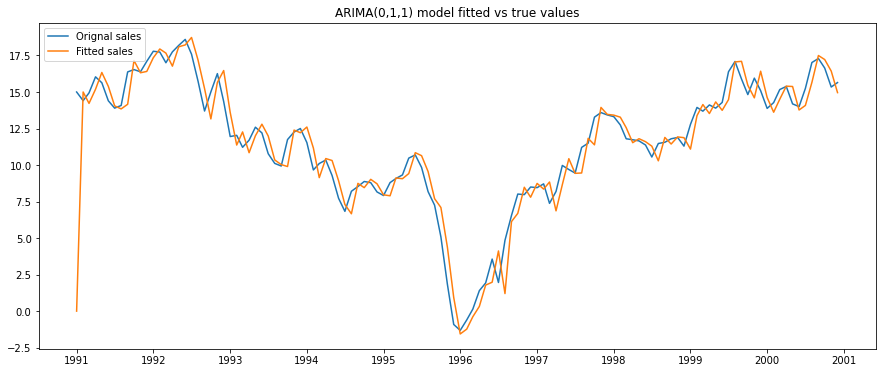

In [22]:
#%%
#p,q = order.aic_min_order[0], order.aic_min_order[1]
# or you can directly assign p,q with 0,1 without training
p,q = 0,1
model_AIC = ARIMA(sales, order=(p, 1, q))
results_AIC_ARIMA = model_AIC.fit()
# Get Fitted Series
fitted_AIC = results_AIC_ARIMA.predict()

# Actual vs Fitted
plt.figure(figsize=(15,6))
plt.plot(sales,label='Orignal sales')
plt.plot(fitted_AIC,label='Fitted sales')
plt.title("ARIMA(0,1,1) model fitted vs true values")
plt.legend(loc=2)
plt.show()

Finally, it is useful to run the Holt-winters' method on the current dataset and compare the forecast performance with the forecast results we have with the $ARIMA(p,d,q)$ model, e.g. using the train/test split. We will leave the task to you.

# Task

In the 2nd task of this week tutorial, we have learnt how to use ARIMA$(p,d,q)$ processes to fit the time series data.
Now you are required to use ARIMA$(p,d,q)$ model to forecast the Shampoo Sales Dataset:
1. Load the dataset and then plot the original data
2. Select a suitable difference order $d$ in order to obtain a stationary data
3. Plot the PACF curve of the differenced data and select a suitable order for AR ($p$) process
4. Plot the ACF curve of the differenced data and select a suitable order for MA ($q$) process
5. Use the selected $p$, $d$, and $q$ to form an ARIMA($p,d,q$) model.
6. Based on the trained ARIMA($p,d,q$) model, generate the forecasted sequence and then calculate the residual.